In [32]:
#数据读取
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import matplotlib.pyplot as plt
breast = load_breast_cancer()
X=pd.DataFrame(breast.data,columns=breast.feature_names)
Y=breast.target

In [82]:
len_X = len(X)
depth = 3
min_on_leafs = int(len_X/(2**(depth+1)))

In [83]:
#训练一个决策树，对规则进行提取
clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=min_on_leafs)
clf = clf.fit(X, Y)

In [84]:
def Get_Rules_From_Tree(clf,X):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves  = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]

    while len(stack) > 0:

        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        is_split_node = children_left[node_id] != children_right[node_id]

        if is_split_node:
            stack.append((children_left[node_id],  depth+1))
            stack.append((children_right[node_id], depth+1))
        else:
            is_leaves[node_id] = True  
    feature_name = [
            X.columns[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in clf.tree_.feature]

    ways  = []
    depth = []
    feat = []
    nodes = []
    rules = []
    for i in range(n_nodes):   
        if  is_leaves[i]: 
            while depth[-1] >= node_depth[i]:
                depth.pop()
                ways.pop()    
                feat.pop()
                nodes.pop()
            if children_left[i-1]==i:#当前节点是上一个节点的左节点，则是小于
                a='{f}<={th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                ways[-1]=a              
                last =' & '.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)
            else:
                a='{f}>{th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                ways[-1]=a
                last = ' & '.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)

        else: #不是叶子节点 入栈
            if i==0:
                ways.append(round(threshold[i],4))
                depth.append(node_depth[i])
                feat.append(feature_name[i])
                nodes.append(i)             
            else: 
                while depth[-1] >= node_depth[i]:
                    depth.pop()
                    ways.pop()
                    feat.pop()
                    nodes.pop()
                if i==children_left[nodes[-1]]:
                    w='{f}<={th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                else:
                    w='{f}>{th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))              
                ways[-1] = w  
                ways.append(round(threshold[i],4))
                depth.append(node_depth[i]) 
                feat.append(feature_name[i])
                nodes.append(i)
                rules
    return rules

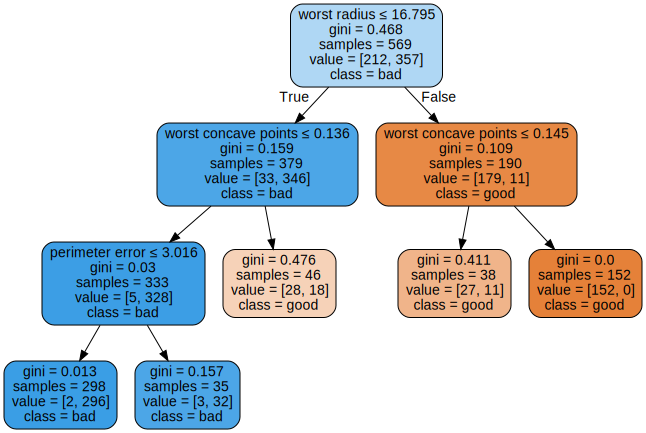

In [85]:
import graphviz 
dot_data = tree.export_graphviz(
                     clf, 
                     out_file=None, 
                     feature_names=X.columns,  
                     class_names=['good','bad'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [87]:
Rules = Get_Rules_From_Tree(clf,X)
rules = []
bad_rate = []
num_good=[]
num_bad = []
for i in Rules:
    rules.append(i.split(':')[0])
    num_good.append(float(i.split(':')[1]))
    num_bad.append(float(i.split(':')[2]))
    bad_rate.append(float(i.split(':')[2])/(float(i.split(':')[1])+float(i.split(':')[2])))
rules_report=pd.DataFrame()
rules_report['rules'] = rules
rules_report['num_good'] = num_good
rules_report['num_bad'] = num_bad
rules_report['bad_rate'] = bad_rate
rules_report.to_csv('rules_report.csv')